# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [1]:
# !pip3 install gym pyvirtualdisplay
# !sudo apt-get install -y xvfb python-opengl ffmpeg

In [2]:
# !pip3 install --upgrade setuptools --user
# !pip3 install ez_setup 
# !pip3 install gym[atari] 
# !pip3 install gym[accept-rom-license] 

In [3]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)  # Should print 11.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"CUDA device: {device}")  # Expected output: "cuda:0" if GPU is available

True
11.8
CUDA device: cuda


For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
# import gym
import gymnasium as gym
import ale_py
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import *
from model import DQN, DQN_LSTM
from config import *
from checkpoint import *
import pickle
import os

import matplotlib.pyplot as plt


In [5]:
# Function to create metadata for checkpointing puposes
def create_metadata(agent, global_episode, global_frame, eval_rewards, rewards, episodes, last_10_ep_losses, loss_tracker):
    return {
    'global_episode': global_episode,
    'global_frame': global_frame,
    'batch_size': BATCH_SIZE,
    'sch_gamma': scheduler_gamma,
    'sch_step_size': scheduler_step_size,
    'tgt_update_freq': update_target_network_frequency,
    'memory capacity': Memory_capacity,  
    'explore steps': EXPLORE_STEPS, 
    'epsilon_decay_rate': agent.epsilon_decay_rate,
    'sticky_action_prob': sticky_action_prob,
    'eval_rewards': eval_rewards,
    'rewards': rewards,
    'episodes': episodes,
    'last_10_ep_losses': last_10_ep_losses,
    'loss_tracker': loss_tracker

    }

In [6]:
import sys
import os

class TeeLogger:
    def __init__(self, filepath):
        self.original_stdout = sys.__stdout__  # raw terminal (useful fallback)
        self.ipython_stdout = sys.stdout       # the notebook's visible output
        self.log = open(filepath, "w")

    def write(self, message):
        self.ipython_stdout.write(message)
        self.log.write(message)
        self.flush()

    def flush(self):
        self.ipython_stdout.flush()
        self.log.flush()

    def close(self):
        self.log.close()

## Understanding the environment

Unlike the UIlliniois assigment this code is based on, I will be using the Gymnasium (https://github.com/farama-Foundation/gymnasium) and the Atari Learning Environment (ALE, link here: https://ale.farama.org/), rather than gym, which has been deprecated.  We will still be playing Breakout on Atari.

To replecate BreakoutDeterministic-v4, as a starting point we'll use ALE/Breakout-v5 with frameskip=4, no "sticky actions" (i.e. deterministic actions), and a limited action space of NOOP, FIRE, LEFT, RIGHT.  However we won't be training on FIRE, instead we will ensure FIRE only happens when the game first starts and when a ball/life is lost.

In [7]:
# env = gym.make('BreakoutDeterministic-v4')
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)  # Use equivalent parameters to BreakoutDeterministic-v4
state = env.reset()

In [8]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #noop, left, and right.  Fire ball (action 1) is not trained

## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

### Create Replay Memory Pickle

In [ ]:

# # # ### Pickle Replay Creator ###
# from gymnasium.wrappers import RecordVideo
# from config import *


# mem_name = 'Buffer_for_testing_using_Run13_new_get_frame'

# #create fresh environment
# env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')
# # env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda ep: ep % 20 == 0)  

# # Choose whether to use double DQN
# double_dqn = False # set to True if using double DQN agent
# if double_dqn:
#     from agent_double import Agent
# else:
#     from agent import Agent

# # print("Instantiating agent")
# agent = Agent(action_size)
# agent.load_policy_net("./save_model/run13/good_Run13_StdDQN_750K_frames_imprvdBatching_2477_eps.pth")
# agent.target_net.load_state_dict(agent.policy_net.state_dict())
# agent.epsilon = 0.1

# frame = 0   
# evaluation_reward = deque(maxlen=evaluation_reward_length)
# rewards, episodes = [], []
# best_eval_reward = 0
# exit_flag = False

# for e in range(EPISODES):
#     done = False
#     score = 0

#     history = np.zeros([5, 84, 84], dtype=np.uint8)
#     step = 0
#     state, _ = env.reset()
#     next_state = state
#     life = number_lives
#     fire_ready = True

#     get_init_state(history, state, HISTORY_SIZE)

#     while not done:
#         step += 1
#         frame += 1

#         # Selet Action (with robust check for FIRE action)
#         if fire_ready:
#             next_state, force_done = reset_after_life_loss(env, history)
#             if force_done:
#                 break
#             action = 1
#             fire_ready = False
#         else:
#             trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
#             action = TRAINABLE_ACTIONS[trainable_action]

#         state = next_state
#         next_state, reward, terminations, truncations, info = env.step(action)  
#         done = truncations or terminations
#         frame_next_state = get_frame(next_state)
#         frame_for_buffer = new_get_frame(next_state)

#         history[4, :, :] = frame_next_state
#         lost_life = check_live(life, info['lives'])  #check if the agent has lost a life

#         if lost_life:
#             fire_ready = True

#         life = info['lives']
#         r = reward

#         # Store the transition in memory if it was not a FIRE action
#         if action in TRAINABLE_ACTIONS:
#             trainable_index = TRAINABLE_ACTIONS.index(action)
#             agent.memory.push(deepcopy(frame_for_buffer), trainable_index, r, lost_life)
#         # When replay buffer is filled save to pickle and break
#         if len(agent.memory) == train_frame:
#             print(f"Memory filled, saving pickle file") 
#             agent.save_replay_buffer(mem_name, frame)
#             exit_flag = True
#             break 
#         score += reward
#         history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame

#         if done:
#             fire_ready = True
#             evaluation_reward.append(score)
#             rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes
#             episodes.append(e)

#             # print episode information 
#             if e % 1 == 0:
#                 print("episode:", e, "  score:", score, "  memory length:",
#                   len(agent.memory), "  epsilon:", agent.epsilon, "  steps:", step,
#                   "  lr:", agent.optimizer.param_groups[0]['lr'], 
#                   "  evaluation reward:", np.mean(evaluation_reward))
#     if exit_flag:
#         break

DQN Agent initialized
No replay buffer path provided. Creating new empty buffer.


c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\agent.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.policy_net.load_state_dict(torch.loa

NameError: name 'get_frame' is not defined

In [ ]:
# # Start logging
# log_file = "./test_log.txt"
# tee = TeeLogger(log_file)
# sys.stdout = tee
# sys.stderr = tee

# print(f"Logging started. Output will be written to both notebook and {log_file}")



In [ ]:
# # Stop logging safely
# sys.stdout = tee.original_stdout
# sys.stderr = tee.original_stdout
# tee.close()

# print("This goes only to the notebook now.")

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

In [9]:
## Setup Run Name and Memory Paths ##
mem_path = None
# mem_path = './checkpoints/Run1_DQN_Serial_20pctExplore_and_Sticky_100000_replay_buffer.pkl'
# mem_path = './checkpoints/Buffer_for_testing_using_Run5_50K_replay_buffer.pkl'
# mem_path = './checkpoints/Buffer_for_testing_using_Run13_new_get_frame_100974_replay_buffer.pkl'
seed = 83

In [ ]:
# log_dir = f"./logs/run{run_num}"
# os.makedirs(log_dir, exist_ok=True)
# log_file = os.path.join(log_dir, f"{run_name}_output.log")
# tee = TeeLogger(log_file)
# sys.stdout = tee
# sys.stderr = tee

# print(f"Logging started. Output will be written to both notebook and {log_file}")

In [10]:

set_seed(seed)

run_num = "12"
name = "DDQN_750K_frames_imprvdBatching"
run_name = "Run"+ str(run_num) + "_" + name

from config import *
from IPython.display import clear_output
from gymnasium.wrappers import RecordVideo

# choose which Agent to use
# from agent_dbl_timediff import Agent
from agent_double import Agent

#create fresh environment
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')  # Use equivalent parameters to BreakoutDeterministic-v4

# setup video recording
def video_trigger(_):
    if len(episodes) == 0:
        return False
    else:
        curr_ep = episodes[-1]
        return (curr_ep > 99 and curr_ep % 100 == 0) 

video_path = f"./videos/run{run_num}"
if not os.path.exists(video_path):
    os.makedirs(video_path)
env = RecordVideo(env, video_folder=video_path, episode_trigger=video_trigger)


print(f"Starting run {run_name}")
train_interval = 1
    
evaluation_reward = deque(maxlen=evaluation_reward_length)
rewards, episodes = [], []
reward = 0
best_eval_reward = curr_mean_reward = last_save_reward = 0

#initialize trackers
## LOSS TRACKERS ##
losses_window = deque(maxlen=10)
loss_history = []
episode_losses = []
loss = mean_loss = 0

# ## Q-VALUE TRACKERS ##
episode_q_means = []
episode_q_maxs = []
episode_q_mins = []
q_mean_window = deque(maxlen=10)
q_max_window = deque(maxlen=10)
q_min_window = deque(maxlen=10)
q_stats_history = {
    'mean': [],
    'max': [],
    'min': [],
    'episode': []
}

# Epsilon Bump Control Variables
plateau_patience = 300
episodes_since_improvement = 0
epsilon_bump = 0.15  # amount to re-increase epsilon
soonest_bump = 2000  # earliest episode to apply epsilon bump

frame = 0
ep_start = 0
training_started_flg = False

print("Instantiating agent")
agent = Agent(action_size, mem_path)
# agent = Agent(action_size)

#########################
#### LOAD CHECKPOINT ####
# metadata = agent.load_checkpoint("Run8_Stdized_DDQN_750K_frames", 2999)  #Edit episode number
# frame = metadata['global_frame']
# agent.load_replay_buffer("Run8_Stdized_DDQN_750K_frames", 711354)
# ep_start = metadata['global_episode']
# evaluation_reward = metadata['eval_rewards']
# rewards = metadata['rewards']    
# episodes = metadata['episodes']
# losses_window = metadata['last_10_ep_losses']
# loss_history = metadata['loss_tracker']
# training_started_flg = True
########################


start_train_immediate = True
frame_max = 750_000

for e in range(ep_start, EPISODES):
    #limit number of frames for consistent testing
    if frame >= frame_max:
        break

    done = False
    score = 0
    episode_losses = []
    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    fire_ready = True
    no_reward_steps = 0

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        
        #limit number of frames for consitent testing
        if frame >= frame_max:
            break

        step += 1
        frame += 1

        # Selet Action (with robust check for FIRE action)
        if fire_ready:
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
        state = next_state
        next_state, reward, terminations, truncations, info = env.step(action)  
        done = truncations or terminations
        
        # Failsafe to force reset if no reward for 3000 steps (prevents agent from getting stuck)
        stuck_limit = 3000
        if no_reward_steps > stuck_limit:
            done = True
            print(f"[WARNING] No reward for {stuck_limit} steps, forcing reset | ", "Episode:", e, "  Frame:", frame, ) 
             
        frame_next_state = get_frame(next_state)
             
        # append next state to history
        history[4, :, :] = frame_next_state
        
        # life handling
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            fire_ready = True
        life = info['lives']
        
        r = reward
        if r == 0:
            no_reward_steps += 1
        else:
            no_reward_steps = 0 

        # Store the transition in replay buffer if it was not a FIRE action
        if action in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(action)
            agent.memory.push(deepcopy(frame_next_state), trainable_index, r, lost_life)
        
        # Start training after random sample generation
        if frame == train_frame or (start_train_immediate and frame == 1):
            print("Starting training")
            training_started_flg = True
        if(frame >= train_frame or start_train_immediate): 
            if frame % train_interval == 0: # Use adaptive training interval
                loss, q_stats = agent.train_policy_net()
                episode_losses.append(loss)
                episode_q_means.append(q_stats['q_mean'])
                episode_q_maxs.append(q_stats['q_max'])
                episode_q_mins.append(q_stats['q_min'])
            # Update the target network
            if (frame % (train_interval * update_target_network_frequency)) == 0:
                agent.update_target_net()
                print("Target network updated at frame: ", frame)
        
        # Update score and history
        score += reward
        history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame
            
        if done:
            fire_ready = True
            evaluation_reward.append(score)            
            episodes.append(e)

            # print episode information every X episodes
            if e % 5 == 0:
                print("episode:", e, "  frame:", frame, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", round(agent.epsilon, 5), 
                  "  steps:", step, "  lr:", agent.optimizer.param_groups[0]['lr'], 
                  "  reward MA:", round(np.mean(evaluation_reward), 3), 
                  "  model train updates:", len(episode_losses), "  mean loss:", round(mean_loss, 5))

            
            if training_started_flg:

                rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes

                # # adapt training interval to agent performance
                # if np.mean(evaluation_reward) < 8:
                #     train_interval = 4
                # elif np.mean(evaluation_reward) < 15:
                #     train_interval = 2
                # else:
                #     train_interval = 1
            
                # save rolling loss everages every X episodes
                if episode_losses:
                    mean_loss = sum(episode_losses) / len(episode_losses)
                    losses_window.append(mean_loss)
                    if e > 9 and e % 10 == 0:
                        loss_history.append((np.mean(losses_window), e))

                # save rolling Q-score averages every X episodes
                # q_mean_window.append(np.mean(episode_q_means))
                # q_max_window.append(np.mean(episode_q_maxs))
                # q_min_window.append(np.mean(episode_q_mins))
                q_stats_history['mean'].append(np.mean(episode_q_means))
                q_stats_history['max'].append(np.mean(episode_q_maxs))
                q_stats_history['min'].append(np.mean(episode_q_mins))
                q_stats_history['episode'].append(e)
                episode_q_means = []
                episode_q_maxs = []
                episode_q_mins = []


                # plot the rewards every X episodes
                if e > 0 and e % 50 == 0:
                    # clear_output(wait=True)
                    pylab.plot(episodes, rewards, 'b')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Episode Scores') 
                    pylab.title('Breakout: DDQN Scores')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_scores.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()
                
                # every X episodes, plot the mean losses
                if e > 0 and e % 50 == 0:
                    x = [entry[1] for entry in loss_history]
                    y = [entry[0] for entry in loss_history]
                    pylab.plot(x, y, 'r')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Loss per Episode') 
                    pylab.title('Breakout: DDQN Loss')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_losses.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()

                # plot Q-value statistics every X episodes
                if e > 0 and e % 25 == 0:
                    pylab.plot(q_stats_history['episode'], q_stats_history['mean'], label='Q-Mean')
                    pylab.plot(q_stats_history['episode'], q_stats_history['max'], label='Q-Max')
                    pylab.plot(q_stats_history['episode'], q_stats_history['min'], label='Q-Min')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Q-Value')
                    pylab.title('Rolling Q-Value Statistics')
                    pylab.legend()
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_Qstats.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()

                # Checkpoint the training process every X episodes 
                if e > 0 and e % 250 == 0:
                    metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history)
                    agent.save_checkpoint(metadata, run_name, e)
                # if e > 0 and e % 500 == 0:
                #     agent.save_replay_buffer(run_name, frame)

                # Check if reward has improved
                curr_mean_reward = np.mean(evaluation_reward)
                if curr_mean_reward > best_eval_reward:
                    best_eval_reward = curr_mean_reward
                    episodes_since_improvement = 0
                else:
                    episodes_since_improvement += 1
                
                # save model if it is good
                if curr_mean_reward > 8 and curr_mean_reward > (1.05 * last_save_reward):
                    model_path = f"./save_model/run{run_num}/good_{run_name}_{e}_eps.pth"
                    os.makedirs(os.path.dirname(model_path), exist_ok=True)
                    torch.save(agent.policy_net.state_dict(), model_path)
                    print(f"[SAVED MODEL] {model_path}")
                    last_save_reward = curr_mean_reward
               
                # # # Apply epsilon bump if plateauing
                # if e > soonest_bump and episodes_since_improvement >= plateau_patience:
                #     if agent.epsilon < agent.epsilon_max:
                #         agent.epsilon = min(agent.epsilon + epsilon_bump, agent.epsilon_max)
                #         print(f"[BUMP] Epsilon bumped to {agent.epsilon:.4f} after {plateau_patience} stagnant episodes.")
                #     episodes_since_improvement = 0  # Reset counter after bump



# Checkpoint the model at the end of training loop
metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history)
agent.save_checkpoint(metadata, run_name, e)
agent.save_replay_buffer(run_name, frame)

print("Training complete")



c:\Users\rbisk\anaconda3\envs\gym\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\videos\run12 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Starting run Run12_DDQN_750K_frames_imprvdBatching
Instantiating agent
Double DQN Agent initialized
No replay buffer path provided. Creating new empty buffer.
Starting training


ValueError: Not enough samples in replay buffer to form a valid mini-batch.

Starting run Run16_StdDQN_750Kfr_timediff_new_get_frame_PER
Instantiating agent
Standard DQN Agent w time diffs initialized
No replay buffer path provided. Creating new empty buffer.
episode: 1   frame: 120   score: 0.0   memory length: 115   epsilon: 1.0   steps: 120   lr: 0.0005   reward MA: 0.0   mean loss: 0   mean max Q: nan
episode: 2   frame: 240   score: 0.0   memory length: 230   epsilon: 1.0   steps: 120   lr: 0.0005   reward MA: 0.0   mean loss: 0   mean max Q: nan
episode: 3   frame: 360   score: 0.0   memory length: 345   epsilon: 1.0   steps: 120   lr: 0.0005   reward MA: 0.0   mean loss: 0   mean max Q: nan
episode: 4   frame: 480   score: 0.0   memory length: 460   epsilon: 1.0   steps: 120   lr: 0.0005   reward MA: 0.0   mean loss: 0   mean max Q: nan
episode: 5   frame: 600   score: 0.0   memory length: 575   epsilon: 1.0   steps: 120   lr: 0.0005   reward MA: 0.0   mean loss: 0   mean max Q: nan
episode: 6   frame: 720   score: 0.0   memory length: 690   epsilon: 1.0

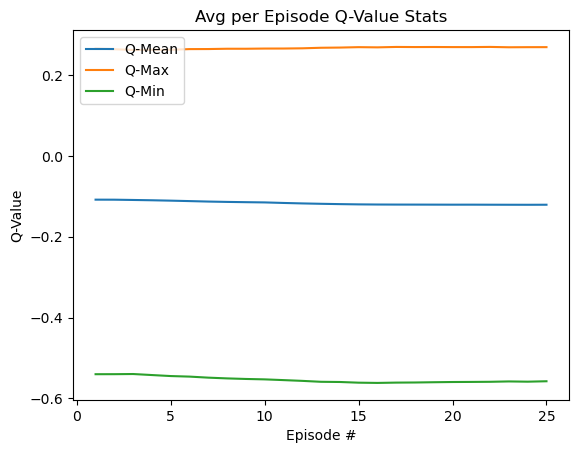

[PLOT DEBUG] Last 5 q_means: [-0.12048882411695608, -0.1206156620064773, -0.12070973680762005, -0.12076982399576283, -0.12066556830707569]
episode: 26   frame: 53921   score: 0.0   memory length: 52126   epsilon: 0.99294   steps: 120   lr: 0.0005   reward MA: 0.92   mean loss: 0.07026   mean max Q: 0.2717
[DEBUG] Q-values: [[-0.33814302 -0.07014906 -0.03738888]] mean: -0.1485603302717209 std: 0.16499850153923035 max: -0.0373888798058033
episode: 27   frame: 54069   score: 1.0   memory length: 52269   epsilon: 0.99267   steps: 148   lr: 0.0005   reward MA: 0.9   mean loss: 0.06931   mean max Q: 0.2657
episode: 28   frame: 54189   score: 0.0   memory length: 52384   epsilon: 0.99246   steps: 120   lr: 0.0005   reward MA: 0.88   mean loss: 0.07239   mean max Q: 0.2705
[DEBUG] Q-values: [[-0.27658176 -0.14582743 -0.08169   ]] mean: -0.16803306341171265 std: 0.09932531416416168 max: -0.0816899985074997
episode: 29   frame: 54309   score: 0.0   memory length: 52499   epsilon: 0.99224   steps

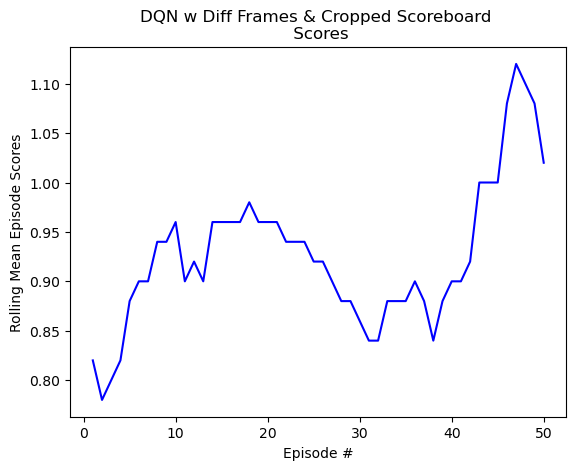

[SAVED PLOT] ./save_graph/run16/Run16_StdDQN_750Kfr_timediff_new_get_frame_PER_ep50_losses.png


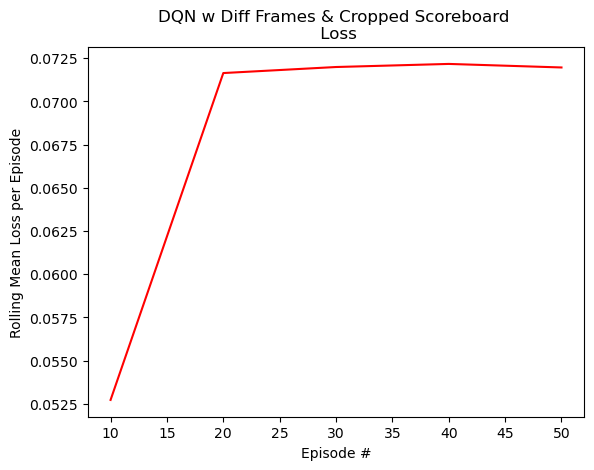

[SAVED PLOT] ./save_graph/run16/Run16_StdDQN_750Kfr_timediff_new_get_frame_PER_ep50_Qstats.png


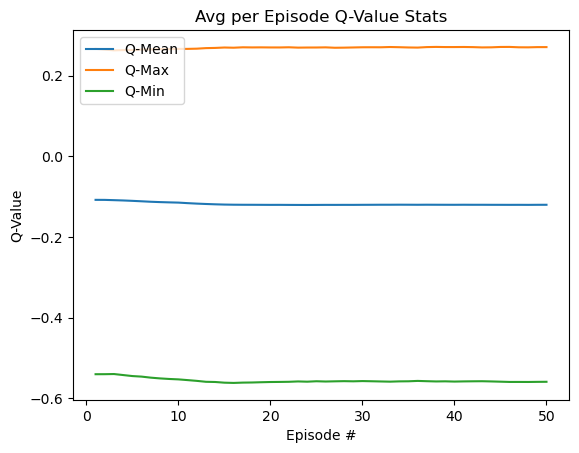

[PLOT DEBUG] Last 5 q_means: [-0.12046347219843564, -0.12042009357469244, -0.12051793741789425, -0.12035691609295474, -0.12031126945394284]
episode: 51   frame: 57915   score: 0.0   memory length: 55995   epsilon: 0.98575   steps: 120   lr: 0.0005   reward MA: 1.0   mean loss: 0.0732   mean max Q: 0.2755
[DEBUG] Q-values: [[-0.40822726 -0.24025196 -0.01953423]] mean: -0.22267115116119385 std: 0.19494199752807617 max: -0.01953423023223877
episode: 52   frame: 58035   score: 0.0   memory length: 56110   epsilon: 0.98554   steps: 120   lr: 0.0005   reward MA: 1.0   mean loss: 0.07096   mean max Q: 0.2646
episode: 53   frame: 58183   score: 1.0   memory length: 56253   epsilon: 0.98527   steps: 148   lr: 0.0005   reward MA: 0.98   mean loss: 0.0709   mean max Q: 0.2632
[DEBUG] Q-values: [[-0.12745488 -0.5474575   0.16792697]] mean: -0.16899514198303223 std: 0.3594968020915985 max: 0.16792696714401245
episode: 54   frame: 58331   score: 1.0   memory length: 56396   epsilon: 0.985   steps: 1

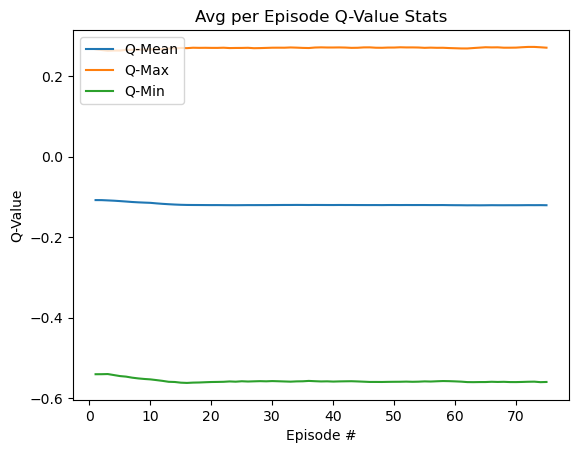

[PLOT DEBUG] Last 5 q_means: [-0.12077806916978191, -0.12062647681331864, -0.12070666341107224, -0.12062286133261602, -0.12083665222714397]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\rbisk\anaconda3\envs\gym\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\rbisk\AppData\Local\Temp\ipykernel_266572\2874097128.py", line 173, in <module>
    loss, q_stats = agent.train_policy_net()
  File "c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\agent_timediff.py", line 68, in train_policy_net
    mini_batch, mini_batch_indices = self.memory.improved_sample_mini_batch(batch_size=BATCH_SIZE)
  File "c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\memory.py", line 37, in improved_sample_mini_batch
  File "c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\memory.py", line 37, in <listcomp>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\rbisk\anaconda3\envs\gym\lib\site-

In [12]:
from config import *

set_seed(seed)
run_num = "16"
name = "StdDQN_750Kfr_timediff_new_get_frame_PER"
run_name = "Run"+ str(run_num) + "_" + name


from config import *
from IPython.display import clear_output
from gymnasium.wrappers import RecordVideo

# choose which Agent to use
from agent_timediff import Agent

#create fresh environment
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode='rgb_array')  # Use equivalent parameters to BreakoutDeterministic-v4

# setup video recording
def video_trigger(_):
    if len(episodes) == 0:
        return False
    else:
        curr_ep = episodes[-1]
        return (curr_ep > 99 and curr_ep % 100 == 0) 

video_path = f"./videos/run{run_num}"
if not os.path.exists(video_path):
    os.makedirs(video_path)
env = RecordVideo(env, video_folder=video_path, episode_trigger=video_trigger)


print(f"Starting run {run_name}")
train_interval = 1
    
evaluation_reward = deque(maxlen=evaluation_reward_length)
rewards, episodes = [], []
reward = 0
best_eval_reward = curr_mean_reward = last_save_reward = 0

#initialize trackers
## LOSS TRACKERS ##
losses_window = deque(maxlen=10)
loss_history = []
episode_losses = []
loss = mean_loss = 0

# ## Q-VALUE TRACKERS ##
episode_q_means = []
episode_q_maxs = []
episode_q_mins = []
q_mean_window = deque(maxlen=10)
q_max_window = deque(maxlen=10)
q_min_window = deque(maxlen=10)
q_stats_history = {
    'mean': [],
    'max': [],
    'min': [],
    'episode': []
}

# Epsilon Bump Control Variables
plateau_patience = 300
episodes_since_improvement = 0
epsilon_bump = 0.15  # amount to re-increase epsilon
soonest_bump = 2000  # earliest episode to apply epsilon bump

frame = 0
ep_start = 0
training_started_flg = False

print("Instantiating agent")
agent = Agent(action_size, mem_path)
# agent = Agent(action_size)

#########################
#### LOAD CHECKPOINT ####
# metadata = agent.load_checkpoint("Run8_Stdized_DDQN_750K_frames", 2999)  #Edit episode number
# frame = metadata['global_frame']
# agent.load_replay_buffer("Run8_Stdized_DDQN_750K_frames", 711354)
# ep_start = metadata['global_episode']
# evaluation_reward = metadata['eval_rewards']
# rewards = metadata['rewards']    
# episodes = metadata['episodes']
# losses_window = metadata['last_10_ep_losses']
# loss_history = metadata['loss_tracker']
# training_started_flg = True
########################


start_train_immediate = False
frame_max = 800_000
e = ep_start

while e < EPISODES:
    #limit number of frames for consistent testing
    if frame >= frame_max:
        break

    done = False
    score = 0
    episode_losses = []
    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state, _ = env.reset()
    next_state = state
    life = number_lives
    fire_ready = True
    no_reward_steps = 0

    get_init_state(history, state, HISTORY_SIZE)

    while not done:
        
        #limit number of frames for consitent testing
        if frame >= frame_max:
            break

        step += 1
        frame += 1

        # Selet Action (with robust check for FIRE action)
        if fire_ready:  
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
        state = next_state
        next_state, reward, terminations, truncations, info = env.step(action)  
        done = truncations or terminations
        
        # Failsafe to force reset if no reward for 3000 steps (prevents agent from getting stuck)
        stuck_limit = 3000
        if no_reward_steps > stuck_limit:
            done = True
            print(f"[WARNING] No reward for {stuck_limit} steps, forcing reset | ", "Episode:", e, "  Frame:", frame, ) 
             
        frame_next_state = new_get_frame(next_state)
             
        # append next state to history
        history[4, :, :] = frame_next_state
        
        # life handling
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            fire_ready = True
        life = info['lives']
        
        r = reward
        if r == 0:
            no_reward_steps += 1
        else:
            no_reward_steps = 0 

        # Store the transition in replay buffer if it was not a FIRE action
        if action in TRAINABLE_ACTIONS:
            trainable_index = TRAINABLE_ACTIONS.index(action)
            agent.memory.push(deepcopy(frame_next_state), trainable_index, r, lost_life)
        
        # Start training after random sample generation
        if frame == train_frame or (start_train_immediate and frame == 1):
            print("Starting training")
            training_started_flg = True
            e = ep_start  #reset episode counter when training starts
        if(training_started_flg): 
            if frame % train_interval == 0: # Use adaptive training interval
                loss, q_stats = agent.train_policy_net()
                episode_losses.append(loss)
                episode_q_means.append(q_stats['q_mean'])
                episode_q_maxs.append(q_stats['q_max'])
                episode_q_mins.append(q_stats['q_min'])
            # Update the target network
            if (frame % (train_interval * update_target_network_frequency)) == 0:
                agent.update_target_net()
                print("Target network updated at frame: ", frame)
        
        # Update score and history
        score += reward
        history[:4, :, :] = history[1:, :, :]  # shift history by one erasing oldest frame
            
        if done:
            e += 1
            fire_ready = True
            evaluation_reward.append(score)            
            

            # print episode information every X episodes
            if e % 1 == 0:
                print("episode:", e, "  frame:", frame, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", round(agent.epsilon, 5), 
                  "  steps:", step, "  lr:", agent.optimizer.param_groups[0]['lr'], 
                  "  reward MA:", round(np.mean(evaluation_reward), 3), 
                  "  mean loss:", round(mean_loss, 5), "  mean max Q:", round(np.mean(episode_q_maxs), 4))
                #   "  latest step Q max:", round(q_stats['q_max'], 4))


            
            if training_started_flg:

                episodes.append(e)
                rewards.append(np.mean(evaluation_reward))  # record moving average of last evaluation_reward_length episodes

                # # adapt training interval to agent performance
                # if np.mean(evaluation_reward) < 8:
                #     train_interval = 4
                # elif np.mean(evaluation_reward) < 15:
                #     train_interval = 2
                # else:
                #     train_interval = 1

                ## DEBUG ##
                # Check TD-error distribution in Replay Buffer
                if e>0 and e % 100 == 0:
                    agent.memory.log_td_error_distribution()

                # save rolling loss everages every X episodes
                if episode_losses:
                    mean_loss = sum(episode_losses) / len(episode_losses)
                    losses_window.append(mean_loss)
                    if e > 9 and e % 10 == 0:
                        loss_history.append((np.mean(losses_window), e))

                # save rolling Q-score stat averages
                q_mean_window.append(np.mean(episode_q_means))
                q_max_window.append(np.mean(episode_q_maxs))
                q_min_window.append(np.mean(episode_q_mins))
                q_stats_history['mean'].append(np.mean(q_mean_window))
                q_stats_history['max'].append(np.mean(q_max_window))
                q_stats_history['min'].append(np.mean(q_min_window))
                q_stats_history['episode'].append(e)
                episode_q_means = []
                episode_q_maxs = []
                episode_q_mins = []

                # plot the rewards every X episodes
                if e > 0 and e % 50 == 0:
                    # clear_output(wait=True)
                    pylab.plot(episodes, rewards, 'b')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Episode Scores') 
                    pylab.title('DQN w Diff Frames & Cropped Scoreboard \n Scores')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_scores.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()
                
                # every X episodes, plot the mean losses
                if e > 0 and e % 50 == 0:
                    x = [entry[1] for entry in loss_history]
                    y = [entry[0] for entry in loss_history]
                    pylab.plot(x, y, 'r')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Rolling Mean Loss per Episode') 
                    pylab.title('DQN w Diff Frames & Cropped Scoreboard \n Loss')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_losses.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()

                # plot Q-value statistics every X episodes
                if e > 0 and e % 25 == 0:
                    pylab.plot(q_stats_history['episode'], q_stats_history['mean'], label='Q-Mean')
                    pylab.plot(q_stats_history['episode'], q_stats_history['max'], label='Q-Max')
                    pylab.plot(q_stats_history['episode'], q_stats_history['min'], label='Q-Min')
                    pylab.xlabel('Episode #')
                    pylab.ylabel('Q-Value')
                    pylab.title('Avg per Episode Q-Value Stats')
                    pylab.legend(loc='upper left')
                    plot_path = f"./save_graph/run{run_num}/{run_name}_ep{e}_Qstats.png"
                    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
                    pylab.savefig(plot_path)
                    print(f"[SAVED PLOT] {plot_path}")
                    pylab.show()
                    pylab.close()


                    ## DEBUG ##
                    print(f"[PLOT DEBUG] Last 5 q_means: {q_stats_history['mean'][-5:]}")

                # Checkpoint the training process every X episodes 
                if e > 0 and e % 250 == 0:
                    metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history)
                    agent.save_checkpoint(metadata, run_name, e)
                # if e > 0 and e % 500 == 0:
                #     agent.save_replay_buffer(run_name, frame)

                # Check if reward has improved
                curr_mean_reward = np.mean(evaluation_reward)
                if curr_mean_reward > best_eval_reward:
                    best_eval_reward = curr_mean_reward
                    episodes_since_improvement = 0
                else:
                    episodes_since_improvement += 1
                
                # save model if it is good
                if curr_mean_reward > 8 and curr_mean_reward > (1.05 * last_save_reward):
                    model_path = f"./save_model/run{run_num}/good_{run_name}_{e}_eps.pth"
                    os.makedirs(os.path.dirname(model_path), exist_ok=True)
                    torch.save(agent.policy_net.state_dict(), model_path)
                    print(f"[SAVED MODEL] {model_path}")
                    last_save_reward = curr_mean_reward
               
                # # # Apply epsilon bump if plateauing
                # if e > soonest_bump and episodes_since_improvement >= plateau_patience:
                #     if agent.epsilon < agent.epsilon_max:
                #         agent.epsilon = min(agent.epsilon + epsilon_bump, agent.epsilon_max)
                #         print(f"[BUMP] Epsilon bumped to {agent.epsilon:.4f} after {plateau_patience} stagnant episodes.")
                #     episodes_since_improvement = 0  # Reset counter after bump



# Checkpoint the model at the end of training loop
metadata = create_metadata(agent, e, frame, evaluation_reward, rewards, episodes, losses_window, loss_history)
agent.save_checkpoint(metadata, run_name, e)
agent.save_replay_buffer(run_name, frame)

print("Training complete")



In [ ]:
# End logging
sys.stdout = tee.ipython_stdout
tee.close()

In [ ]:
# metadata = create_metadata(agent, 1879, frame, evaluation_reward, rewards, episodes, losses_window, loss_history)
# agent.save_checkpoint(metadata, run_name, 1879)
# agent.save_replay_buffer(run_name, frame)

In [ ]:
print(episodes)

[SAVED PLOT] ./presentation_assets/DQN_750K_steps_SCORES.png


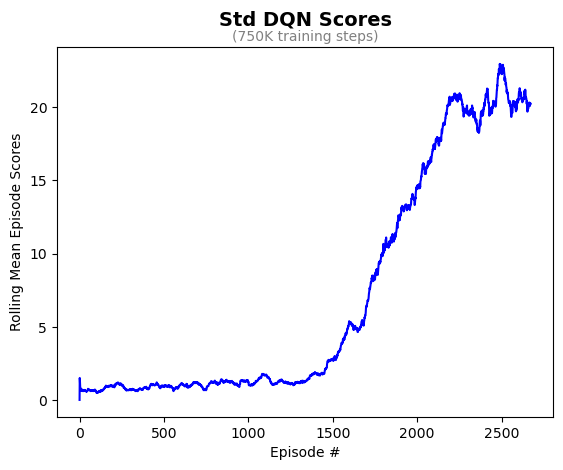

In [ ]:
import pylab
import os

pylab.plot(episodes, rewards, 'b')
pylab.xlabel('Episode #')
pylab.ylabel('Rolling Mean Episode Scores')

# Main title
pylab.text(0.5, 1.05, 'Std DQN Scores',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=14, fontweight='semibold')

# Subtitle (smaller font)
pylab.text(0.5, 1.01, '(750K training steps)',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=10, color='gray')

plot_path = f"./presentation_assets/DQN_750K_steps_SCORES.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
pylab.savefig(plot_path, bbox_inches='tight')
print(f"[SAVED PLOT] {plot_path}")
pylab.show()
pylab.close()


C:\Users\rbisk\AppData\Local\Temp\ipykernel_175372\762919505.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddqn_ckpt = torch.load("./checkpoints/Run12_DDQN_750K_frames

[SAVED PLOT] ./presentation_assets/DQN_vs_DDQN_750K_steps_LOSSES.png


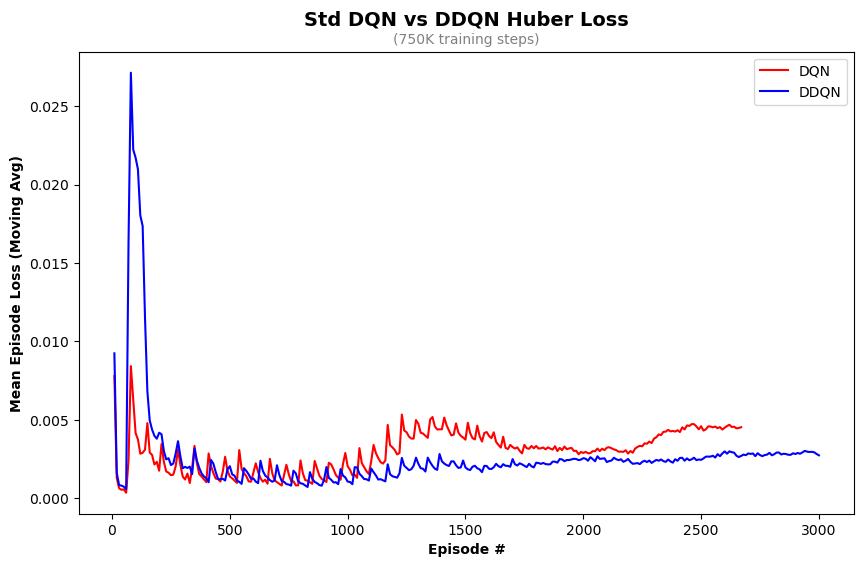

In [ ]:

# === Load checkpoint files ===
ddqn_ckpt = torch.load("./checkpoints/Run12_DDQN_750K_frames_imprvdBatching_3007_checkpoint.pt")
dqn_ckpt  = torch.load("./checkpoints/Run13_StdDQN_750K_frames_imprvdBatching_2673_checkpoint.pt")

# === Extract metadata ===
ddqn_meta = ddqn_ckpt["metadata"]
dqn_meta = dqn_ckpt["metadata"]

# # === Extract episode indices and rolling mean rewards ===
# ddqn_episodes = ddqn_meta["episodes"]
# ddqn_rewards = ddqn_meta["rewards"]

# dqn_episodes = dqn_meta["episodes"]
# dqn_rewards = dqn_meta["rewards"]

# # === Plot ===
# plt.figure(figsize=(10, 6))
# plt.plot(dqn_episodes, dqn_rewards, label="DQN", color="red")
# plt.plot(ddqn_episodes, ddqn_rewards, label="DDQN", color="blue")
# plt.xlabel("Episode #", fontweight="bold")
# plt.ylabel("Mean Episode Score (Moving Avg)", fontweight="bold")
# plt.legend(loc = "upper left")
# # Main title
# pylab.text(0.5, 1.05, 'Std DQN vs DDQN Scores',
#            ha='center', va='bottom', transform=pylab.gca().transAxes,
#            fontsize=14, fontweight='semibold')

# # Subtitle (smaller font)
# pylab.text(0.5, 1.01, '(750K training steps)',
#            ha='center', va='bottom', transform=pylab.gca().transAxes,
#            fontsize=10, color='gray')


# plot_path = f"./presentation_assets/DQN_vs_DDQN_750K_steps_SCORES.png"
# os.makedirs(os.path.dirname(plot_path), exist_ok=True)
# pylab.savefig(plot_path, bbox_inches='tight')
# print(f"[SAVED PLOT] {plot_path}")
# plt.show()


# # === Extract loss data ===
ddqn_loss_history = ddqn_meta["loss_tracker"]
dqn_loss_history = dqn_meta["loss_tracker"]

ddqn_episodes = [entry[1] for entry in ddqn_loss_history]
ddqn_losses = [entry[0] for entry in ddqn_loss_history]

dqn_episodes = [entry[1] for entry in dqn_loss_history]
dqn_losses = [entry[0] for entry in dqn_loss_history]

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(dqn_episodes, dqn_losses, label="DQN", color="red")
plt.plot(ddqn_episodes, ddqn_losses, label="DDQN", color="blue")
plt.xlabel("Episode #", fontweight="bold")
plt.ylabel("Mean Episode Loss (Moving Avg)", fontweight="bold")
plt.legend(loc = "best")
# Main title
pylab.text(0.5, 1.05, 'Std DQN vs DDQN Huber Loss',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=14, fontweight='semibold')

# Subtitle (smaller font)
pylab.text(0.5, 1.01, '(750K training steps)',
           ha='center', va='bottom', transform=pylab.gca().transAxes,
           fontsize=10, color='gray')


plot_path = f"./presentation_assets/DQN_vs_DDQN_750K_steps_LOSSES.png"
os.makedirs(os.path.dirname(plot_path), exist_ok=True)
pylab.savefig(plot_path, bbox_inches='tight')
print(f"[SAVED PLOT] {plot_path}")
plt.show()


In [ ]:
# chkpt = torch.load("./checkpoints/Run12_DDQN_750K_frames_imprvdBatching_3007_checkpoint.pt")
from model import DQN
action_size = len(TRAINABLE_ACTIONS)
model = DQN(action_size)
model.eval()

#create dummy input for model
dummy_input = torch.rand(BATCH_SIZE, 4, 84, 84)

#export to ONNX
torch.onnx.export(model, dummy_input, "Basic Network.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
                  opset_version=11)

print("ONNX model exported successfully!")


ONNX model exported successfully!


In [ ]:
import onnx
model = onnx.load("Basic Network.onnx")
for node in model.graph.node:
    if node.op_type == "Gemm":
        node.name = "FC"
onnx.save(model, "model_with_FC_labels.onnx")

## Timediff Frames

Instead of using a 4 frame history to train the model, here we will feed the model the 4 frames plus the "diff" between each of the 4 frames to help isolate the ball position which is the most important thing for the model to learn

# Visualize Agent Performance

BE AWARE THIS CODE BELOW MAY CRASH THE KERNEL IF YOU RUN THE SAME CELL TWICE.

Please save your model before running this portion of the code.

In [ ]:
# torch.save(agent.policy_net, "./save_model/breakout_dqn_latest.pth")

### Play Game in Window or Save Video

In [8]:
from agent import Agent
#load checkpoint
# checkpoint = torch.load("./save_model/Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS_2000_checkpoint.pt")
agent = Agent(3)
metadata = agent.load_checkpoint("Run17_StdDQN_750Kfr_newest_get_frame_CirularPER_wIS", 2000)
print(metadata.keys())

DQN Agent initialized
No replay buffer path provided. Creating new empty standard replay buffer.
Checkpoint for episode 2000 loaded
dict_keys(['global_episode', 'global_frame', 'batch_size', 'sch_gamma', 'sch_step_size', 'tgt_update_freq', 'memory capacity', 'explore steps', 'epsilon_decay_rate', 'sticky_action_prob', 'eval_rewards', 'rewards', 'episodes', 'last_10_ep_losses', 'loss_tracker', 'epislon', 'per_beta', 'epsilon'])


c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\agent.py:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [26]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from utils import *

for _ in range(5):
    # set random seed to sync visual and recorded game
    seed = random.randint(0, 10000)
    set_seed(seed)

    # Load and setup Agent
    print("Instantiating agent")
    # agent = Agent(action_size)
    # agent.load_policy_net("./save_model/run3/good_Run3_DDQN_Serial_InvTimeEpsilon_ddqn_886_eps.pth")
    agent.policy_net.eval()
    agent.epsilon = 0  # Set agent to only exploit the best action


    # Create environments
    env_human = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0, full_action_space=False, render_mode="human")
    # env_record = RecordVideo(env_record, video_folder="./videos", episode_trigger=lambda e: True)

    # Reset to seed
    obs, _ = env_human.reset(seed=seed)


    # Setup History
    history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
    get_init_state(history, obs, HISTORY_SIZE)

    done = False
    fire_ready = True
    life = 5
    score = 0
    step = 0

    while not done:
        step += 1

        # Selet Action (with robust check for FIRE action)
        if fire_ready:  
            next_state, force_done = reset_after_life_loss(env_human, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
        obs, reward, term, trunc, info = env_human.step(action)
        done = term or trunc

        # update history
        frame_next_state = get_frame(obs)
        history[4, :, :] = frame_next_state
        history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
        
        # check if life has been lost
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            print(f"[DEBUG] Lost life detected at step {step}")
            fire_ready = True
        life = info['lives']
        
        # keep track of score
        score += reward # update total score

    env_human.close()


Instantiating agent
[DEBUG] Lost life detected at step 101
[DEBUG] Lost life detected at step 125
[DEBUG] Lost life detected at step 179
[DEBUG] Lost life detected at step 234
[DEBUG] Lost life detected at step 290
Instantiating agent
[DEBUG] Lost life detected at step 101
[DEBUG] Lost life detected at step 125
[DEBUG] Lost life detected at step 179
[DEBUG] Lost life detected at step 234
[DEBUG] Lost life detected at step 290
Instantiating agent
[DEBUG] Lost life detected at step 101
[DEBUG] Lost life detected at step 125
[DEBUG] Lost life detected at step 179
[DEBUG] Lost life detected at step 234
[DEBUG] Lost life detected at step 290
Instantiating agent
[DEBUG] Lost life detected at step 101
[DEBUG] Lost life detected at step 125
[DEBUG] Lost life detected at step 179
[DEBUG] Lost life detected at step 234
[DEBUG] Lost life detected at step 290
Instantiating agent
[DEBUG] Lost life detected at step 101
[DEBUG] Lost life detected at step 125
[DEBUG] Lost life detected at step 179
[DE

### Play Game Rendered in Jupyter Notebook

In [ ]:
from IPython.display import display as ipythondisplay, clear_output

def show_state_live(frame, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(frame)
    plt.title(f"Step: {step} {info}")
    plt.axis('off')
    clear_output(wait=True)
    ipythondisplay(plt.gcf())

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo


# set random seed to sync visual and recorded game
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Load and setup Agent
# Choose whether to use double DQN
double_dqn = False # set to True if using double DQN agent
if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

#Initialize agent
print("Instantiating agent")
agent = Agent(action_size)
agent.load_policy_net("./save_model/Run1_serial/good_breakout_dqn_1256_eps.pth")
agent.policy_net.eval()
agent.epsilon = 0  # Set agent to only exploit the best action


# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=sticky_action_prob, full_action_space=False, render_mode="rgb_array")
# Use RecordVideo to save the video to the "videos" directory
# env = RecordVideo(env, video_folder="./videos", episode_trigger=lambda episode_id: True)

# Reset the environment
state, _ = env.reset(seed=seed)

# Setup History
history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
get_init_state(history, state, HISTORY_SIZE)

#Initialize variables
step = 0
done = False
fire_ready = True
life = number_lives
score = 0

while not done:

    # Render the current frame live in the notebook
    show_state_live(state, step)   

    # Select action
    if fire_ready:
        action = 1
        fire_ready = False
    else:
        model_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        action = TRAINABLE_ACTIONS[model_action]

    # Step the environment
    next_state, reward, term, trunc, info = env.step(action)
    done = term or trunc

    # update history
    frame_next_state = get_frame(state)
    history[4, :, :] = frame_next_state
    history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
    
    # check if life has been lost
    lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
    if lost_life:
        fire_ready = True  
        # do_random_actions(env_human, 30) #IMPT: introduce randomness to game and paddle position before next life
    life = info['lives']
    
    # keep track of score
    score += reward # update total score

    state = next_state
    step += 1

    

env.close()

## Model Comparison Tester

In [30]:
from utils import *
from config import *
import gymnasium as gym



# Load and setup Agent
# Choose which agent class to load
from agent import Agent
# from agent_timediff import Agent

# 50 unique, fixed seeds
seeds = [765,817,53,705,990,511,236,661,654,418,804,968,1,749,125,293,985,574, 
         447,948,687,317,280,645,927,842,309,616,717,930,778,323,595,798,195,11,
         483,316,690,951,196,307,906,558,516,844,410,965,371,886]


#Initialize agent
print("Instantiating agent")
agent = Agent(action_size)
# agent.load_policy_net("./save_model/run12/good_Run12_DDQN_750K_frames_imprvdBatching_2319_eps.pth")
agent.load_policy_net("./save_model/run13/good_Run13_StdDQN_750K_frames_imprvdBatching_2477_eps.pth")
# agent.load_policy_net("./save_model/run14/good_Run14_StdDQN_750Kfr_timediff_new_get_frame_2425_eps.pth")
agent.target_net.load_state_dict(agent.policy_net.state_dict())
agent.target_net.eval()
agent.policy_net.eval()
agent.epsilon = 0.05  # Set agent to use model action 95% of the time for robustness


# Create environments
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False, render_mode="rgb_array")
# Use RecordVideo to save the video to the "videos" directory
video_path = f"./videos/testing/run13"
if not os.path.exists(video_path):
    os.makedirs(video_path)
env = RecordVideo(env, video_folder=video_path, episode_trigger=lambda e: True)


scores = []

for e, seed in enumerate(seeds):
    set_seed(seed)
    # Reset the environment
    state, _ = env.reset(seed=seed)

    # Setup History
    history = np.zeros([HISTORY_SIZE + 1, 84, 84], dtype=np.uint8)
    get_init_state(history, state, HISTORY_SIZE)  #non cropped version
    # new_get_init_state(history, state, HISTORY_SIZE)  #cropped version

    #Initialize variables
    step = 0
    done = False
    fire_ready = True
    life = number_lives
    score = 0

    while not done:
        
        # Selet Action (with robust check for FIRE action)
        if fire_ready:
            next_state, force_done = reset_after_life_loss(env, history)
            if force_done:
                break
            action = 1
            fire_ready = False
        else:
            trainable_action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
            action = TRAINABLE_ACTIONS[trainable_action]

        # Step the environment
    
        next_state, reward, term, trunc, info = env.step(action)
        done = term or trunc
        # update total score
        score += reward 

        # update history
        history[4, :, :] = get_frame(next_state)  #non cropped version
        # history[4, :, :] = new_get_frame(next_state)  #cropped version
        history[:4, :, :] = history[1:, :, :]  #shift history by one erasing oldest frame
        
        # check if life has been lost
        lost_life = check_live(life, info['lives'])  #check if the agent has lost a life
        if lost_life:
            fire_ready = True  
        life = info['lives']
        
        
        step += 1
    
    print("episode:", e, "  seed:", seed, "  score:", score, "  epsilon:", round(agent.epsilon, 5), 
    "  steps:", step)
    
    scores.append(score)

env.close()
print("Mean Score: ", np.mean(scores))
print("Std Score: ", np.std(scores))
print("Max Score: ", np.max(scores))
print("Min Score: ", np.min(scores))
print("Median Score: ", np.median(scores))

        

env.close()

Instantiating agent
DQN Agent initialized
No replay buffer path provided. Creating new empty buffer.


c:\Users\rbisk\Dropbox\GMU\cs747 Deep Learning\Final_Project\Illinois_hw\agent.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.policy_net.load_state_dict(torch.loa

episode: 0   seed: 765   score: 29.0   epsilon: 0.05   steps: 603
episode: 1   seed: 817   score: 30.0   epsilon: 0.05   steps: 622
episode: 2   seed: 53   score: 22.0   epsilon: 0.05   steps: 523
episode: 3   seed: 705   score: 23.0   epsilon: 0.05   steps: 764
episode: 4   seed: 990   score: 23.0   epsilon: 0.05   steps: 466
episode: 5   seed: 511   score: 17.0   epsilon: 0.05   steps: 484
episode: 6   seed: 236   score: 23.0   epsilon: 0.05   steps: 432
episode: 7   seed: 661   score: 22.0   epsilon: 0.05   steps: 484
episode: 8   seed: 654   score: 24.0   epsilon: 0.05   steps: 588
episode: 9   seed: 418   score: 34.0   epsilon: 0.05   steps: 562
episode: 10   seed: 804   score: 23.0   epsilon: 0.05   steps: 502
episode: 11   seed: 968   score: 30.0   epsilon: 0.05   steps: 558
episode: 12   seed: 1   score: 21.0   epsilon: 0.05   steps: 492
episode: 13   seed: 749   score: 25.0   epsilon: 0.05   steps: 508
episode: 14   seed: 125   score: 19.0   epsilon: 0.05   steps: 424
episode:

## SCRATCH

In [ ]:
for i in range(4):
    print(i)


In [ ]:
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.0, full_action_space=False)
env.reset()
next_state, reward, terminations, truncations, info = env.step(torch.tensor([[1]]))
done = truncations or terminations
print("reward: ", reward)
print("done: ", done)
print("info: ", info)
print(next_state.shape)

In [ ]:
print(env.action_space)
print("Expected type:", type(env.action_space.sample()))

In [ ]:
print("agent memory type: ", type(agent.memory.memory[0]))
print("agent memory[0]: ", agent.memory.memory[0])

In [2]:
import time
t0 = time.time()
for _ in range(1000):
    print(".")  # simulate 1000 rapid prints
print("\nElapsed:", time.time() - t0)


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


[[70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8626497  79.46032934]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8626497  79.46032934]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 [70.8633982  79.4251497 ]
 

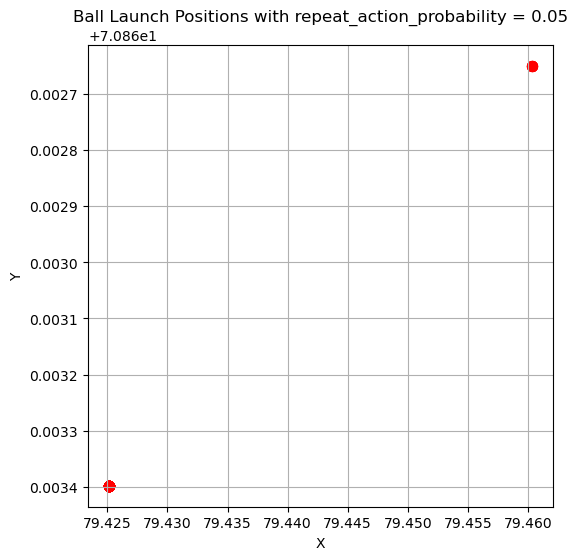

: 

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

def extract_ball_position(frame):
    """Extracts the approximate ball position from a rendered frame."""
    gray = np.mean(frame, axis=2)  # Convert to grayscale
    ball_mask = gray > 100         # Bright ball pixels
    coords = np.argwhere(ball_mask)
    return np.mean(coords, axis=0) if coords.size > 0 else None

repeat_action_probability = 0.05 # Try 0.0, 0.01, or 0.25
positions = []

for i in range(100):
    env = gym.make("ALE/Breakout-v5", render_mode="rgb_array", repeat_action_probability=repeat_action_probability)
    # if hasattr(env.unwrapped, "ale"):
    #     env.unwrapped.ale.setMode(1)
    env.reset(seed=i)
    env.step(1)  # FIRE
    obs = None
    for _ in range(5):
        obs, _, _, _, _ = env.step(0)
    # plt.imshow(obs)
    # plt.title(f"Frame after ball launch (seed {i})")
    # plt.axis('off')
    # plt.show()
    env.close()

    pos = extract_ball_position(obs)
    if pos is not None and len(pos) == 2:
        positions.append(pos)

positions = np.array(positions)

if len(positions) == 0:
    print("❌ No ball positions detected — check brightness threshold or frame steps.")
else:
    print(positions)
    plt.figure(figsize=(6, 6))
    plt.scatter(positions[:, 1], positions[:, 0], c='red', s=50)
    plt.title(f"Ball Launch Positions with repeat_action_probability = {repeat_action_probability}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()